## DengAI RNN Notebook
This notebook was created to explore applying RNN's to the DengAI time series data. Several model architectures and feature combinations were employed including:

- Simple RNN
- LSTM 
- GRU
- Wavenet

In [ ]:
#Run the utils notebook
%run DengAI-Utils.ipynb


##### Run SJ
Warmup the model and then auto-regress it

##### Model Warmup for SJ
Run the model initially with the training data to get the model trained

In [22]:
lag_sj=1
n_units_sj=166
BATCH_SIZE = 16
BUFFER_SIZE = 500

#Start timer
s_time=datetime.now()
print('-'*25)
print('Started model warmup at ' + str(s_time))

#Prep datasets
x_train_sj, y_train_sj, x_test_sj, y_test_sj, x_valid_sj, y_valid_sj, x_holdout_sj, x_all_sj, y_all_sj, scaler_sj=pre_process_data_for_RNN(
    city='sj',lag=lag_sj,train_split=.8,test_split=.1,valid_split=.1)

#reformat x data sets for DNN model - 3d down to 2d
#x_train_sj_flat=x_train_sj.reshape(x_train_sj.shape[0],x_train_sj.shape[1]*x_train_sj.shape[2])
#x_test_sj_flat=x_test_sj.reshape(x_test_sj.shape[0],x_test_sj.shape[1]*x_test_sj.shape[2])

#Set up repeated copies of shuffled data
train_sj_data_single = tf.data.Dataset.from_tensor_slices((x_train_sj, y_train_sj))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#Define models
model_sj=create_model_sj(x_sj=x_train_sj,n_units=n_units_sj,activate='selu')

#Fit the models
history_sj=fit_model_sj(model=model_sj,n_epochs=500,x_train=train_sj_data_single,y_train=y_train_sj,x_test=x_test_sj,y_test=y_test_sj)

#Evaluate the model
model_sj.evaluate(x_test_sj, y_test_sj)

print('-'*25)
#end timer
e_time=datetime.now()
exec_time=e_time-s_time
print('Warmup complete - Execution time:' + str(exec_time) + '. Warmup completed at ' + str(e_time))



-------------------------
Started model warmup at 2020-10-29 16:49:39.351166
3/3 [==============================] - 0s 2ms/step - loss: 20.7680 - mae: 20.7680
-------------------------
Warmup complete - Execution time:0:00:26.520584. Warmup completed at 2020-10-29 16:50:05.871750


MAE for y_hat and y_valid:18.78723404255319


<AxesSubplot:xlabel='week', ylabel='y_hat'>

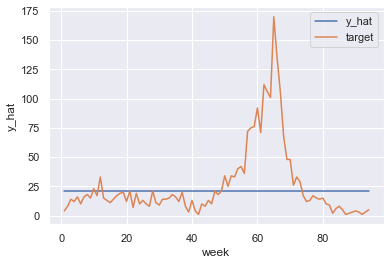

In [20]:
#x_valid_sj_flat=x_valid_sj.reshape(x_valid_sj.shape[0],x_valid_sj.shape[1]*x_valid_sj.shape[2])
y_hat_sj=model_sj.predict(x_valid_sj)
y_hat_sj=y_hat_sj[:,-1]
y_hat_sj=y_hat_sj.astype(int)
y_hat_sj=np.where(y_hat_sj>0,y_hat_sj,0)
#print(y_hat_sj)

#Print the MAE for predictions and targets from generated holdout
print('MAE for y_hat and y_valid:' + str(mean_absolute_error(y_hat_sj,y_valid_sj)))

#Print the predicted amounts against the targets
df_pred=pd.DataFrame(data=y_hat_sj)
df_pred['week']=range(1,len(y_hat_sj)+1)
df_pred['y_hat']=df_pred[0]
df_pred['targets']=y_valid_sj
df_pred=df_pred.iloc[:,1:]

sns.lineplot(data=df_pred,x='week',y='y_hat',legend='brief',label='y_hat')
sns.lineplot(data=df_pred,x='week',y='targets',legend='brief',label='target')

In [ ]:
#flatten the valid file
x_valid_sj_flat=x_valid_sj.reshape(x_valid_sj.shape[0],x_valid_sj.shape[1]*x_valid_sj.shape[2])

y_hat_sj=model_sj.predict(x_valid_sj_flat)
for i in range(len(y_hat_sj)): y_hat_sj[i]=int(y_hat_sj[i])



##### Model Auto regression for SJ
Feed the validation or holdout data into the model one series at a time and retrain the model at each step

In [47]:
lag=2
test_split=.1
  
#Once model is warmed up, go through each record in holdout, create a prediction, and re-fit the model
y_valid_sj_orig=y_valid_sj.copy()
y_hat_sj=[]

#Start timer
s_time=datetime.now()
print('-'*25)
print('Started auto-regress at ' + str(s_time))

for i in range(len(x_all_sj)-len(x_holdout_sj)-len(x_valid_sj),len(x_all_sj)-len(x_holdout_sj)): 
#for i in range(len(x_all_sj)-len(x_holdout_sj),len(x_all_sj)):
    #predict the value of y - prediction will be unscaled
    #x_predicter=x_all_sj[[i],:,:].reshape(x_all_sj[[i],:,:].shape[0],x_all_sj[[i],:,:].shape[1]*x_all_sj[[i],:,:].shape[2])
    #y_pred=model_sj.predict(x_predicter)
    y_pred=model_sj.predict(x_all_sj[[i],:,:])
    
    #Get the y value and create a 2d record to feed into the scaler.
    x_sc=x_all_sj[[i],-1,:]
    x_sc[0,-1]=y_pred[:,-1,-1]
    x_sc=scaler_sj.transform(x_sc)
    y_pred_sc=x_sc[0,-1]
    
    #update x_all and y_all with the scaled predicted value and predicted value
    x_all_sj=forward_lag(x_all_sj,x_val=y_pred_sc,row_num=i+1,lag=lag)
    y_all_sj[i,-1]=int(y_pred[:,-1,-1])
    y_hat_sj.append(int(y_pred[:,-1,-1]))
    
    #re-slice the test and training sets
    x_train_sj=x_all_sj[:i,:,:]
    x_test_sj=x_all_sj[int(len(x_train_sj)*test_split)+1:i+1,:,:] #test and train will overlap with the last part of train being used for test
    y_train_sj=y_all_sj[:i,-1]
    y_test_sj=y_all_sj[int(len(y_train_sj)*test_split)+1:i+1]
    
    #update the model
    history_sj=fit_model_sj(model=model_sj,n_epochs=5,x_train=x_train_sj,y_train=y_train_sj,x_test=x_test_sj,y_test=y_test_sj)
    #model_sj.reset_states()
    
print('-'*25)
#end timer
e_time=datetime.now()
exec_time=e_time-s_time
print('Auto regress complete - Execution time:' + str(exec_time) + ' started at ' + str(s_time) + ' ended at ' + str(e_time))
    

-------------------------
Started auto-regress at 2020-10-27 15:33:16.228306
-------------------------
Auto regress complete - Execution time:0:00:43.650941 started at 2020-10-27 15:33:16.228306 ended at 2020-10-27 15:33:59.879247


In [125]:
#Print the MAE for predictions and targets from generated holdout
print('MAE for y_hat and y_valid:' + str(mean_absolute_error(y_hat_sj,y_valid_sj)))
    

MAE for y_hat and y_valid:17.67391304347826


<AxesSubplot:xlabel='week', ylabel='y_hat'>

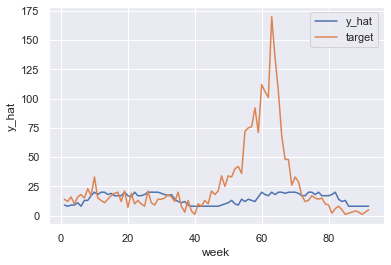

In [126]:
#Print the predicted amounts against the targets
df_pred=pd.DataFrame(data=y_hat_sj)
df_pred['week']=range(1,len(y_hat_sj)+1)
df_pred['y_hat']=df_pred[0]
df_pred['targets']=y_valid_sj
df_pred=df_pred.iloc[:,1:]

sns.lineplot(data=df_pred,x='week',y='y_hat',legend='brief',label='y_hat')
sns.lineplot(data=df_pred,x='week',y='targets',legend='brief',label='target')



<AxesSubplot:>

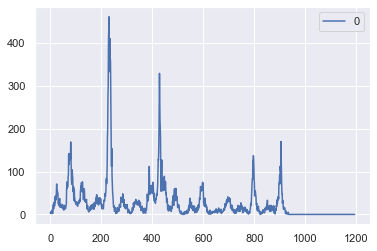

In [17]:
df=pd.DataFrame(y_all_sj)
sns.lineplot(data=df)

##### Model Warmup for IQ
Run the model initially with the training data to get the model trained

In [16]:
lag_iq=1
n_units_iq=128

#Start timer
s_time=datetime.now()

#Prep datasets
x_train_iq, y_train_iq, x_test_iq, y_test_iq, x_valid_iq, y_valid_iq, x_holdout_iq, x_all_iq, y_all_iq, scaler_iq=pre_process_data_for_RNN(
    city='iq',lag=lag_iq,train_split=.8,test_split=.1,valid_split=.1)

#Define models
model_iq=create_model_iq(x_iq=x_train_iq,n_units=n_units_iq)

#Fit the models
history_iq=fit_model_iq(model=model_iq,n_epochs=200,x_train=x_train_iq,y_train=y_train_iq,x_test=x_test_iq,y_test=y_test_iq)

#Evaluate the model
model_iq.evaluate(x_test_iq, y_test_iq)

print('-'*25)
#end timer
e_time=datetime.now()
exec_time=e_time-s_time
print('Execution time:' + str(exec_time))

2/2 [==============================] - 0s 1ms/step - loss: 9.8866 - mae: 9.8866
-------------------------
Execution time:0:00:06.887062


In [17]:
y_hat_iq=model_iq.predict(x_valid_iq)
y_hat_iq=y_hat_iq[:,-1]
for i in range(len(y_hat_iq)): y_hat_iq[i]=int(y_hat_iq[i])
#print(y_hat_iq)

##### Model Auto regression for IQ
Feed the validation or holdout data into the model one series at a time and retrain the model at each step

In [ ]:
#Once model is warmed up, go through each record in holdout, create a prediction, and re-fit the model
y_valid_iq_orig=y_valid_iq.copy()
y_hat_iq=[]
lag=50
test_split=.20

#for i in range(len(x_all_iq)-len(x_holdout_iq)-len(x_valid_iq),len(x_all_iq)-len(x_holdout_iq)):
for i in range(len(x_all_iq)-len(x_holdout_iq),len(x_all_iq)):
    #predict the value of y - prediction will be unscaled
    y_pred=model_iq.predict(x_all_iq[[i],:,:])
    
    #Get the y value and create a 2d record to feed into the scaler.
    x_sc=x_all_iq[[i],-1,:]
    x_sc[0,-1]=y_pred
    x_sc=scaler_iq.transform(x_sc)
    y_pred_sc=x_sc[0,-1]
    
    #update x_all and y_all with the scaled predicted value and predicted value
    x_all_iq=forward_lag(x_all_iq,x_val=y_pred_sc,row_num=i+1,lag=lag)
    y_all_iq[i,-1]=int(y_pred)
    y_hat_iq.append(int(y_pred))
    
    #re-slice the test and training sets
    x_train_iq=x_all_iq[:i,:,:]
    x_test_iq=x_all_iq[int(len(x_train_iq)*test_split-1):i,:,:] #test and train will overlap with the last part of train being used for test
    y_train_iq=y_all_iq[:i,-1]
    y_test_iq=y_all_iq[int(len(y_train_iq)*test_split-1):i]
    
    #update the model
    history_iq=fit_model_iq(model=model_iq,n_epochs=2,x_train=x_train_iq,y_train=y_train_iq,x_test=x_test_iq,y_test=y_test_iq)
    model_iq.reset_states()
    

In [18]:
mean_absolute_error(y_hat_iq,y_valid_iq)

3.8076923076923075

<AxesSubplot:xlabel='week', ylabel='y_hat'>

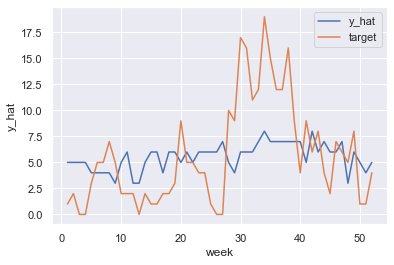

In [19]:
df_pred=pd.DataFrame(data=y_hat_iq)
df_pred['week']=range(1,len(y_hat_iq)+1)
df_pred['y_hat']=df_pred[0]
df_pred['targets']=y_valid_iq
df_pred=df_pred.iloc[:,1:]
df_pred.head()
sns.lineplot(data=df_pred,x='week',y='y_hat',legend='brief',label='y_hat')
sns.lineplot(data=df_pred,x='week',y='targets',legend='brief',label='target')


In [ ]:
y_sub_sj=y_all_sj[len(y_all_sj)-len(x_holdout_sj):]
y_sub_iq=y_all_iq[len(y_all_iq)-len(x_holdout_iq):]

#Create the submit file
create_submit_file(y_sub_sj,y_sub_iq)


In [ ]:
y_pred_sj=model_sj.predict(x_valid_sj)
print('MAE of SJ: '+ str(mean_absolute_error(y_pred_sj,y_valid_sj)))
y_pred_iq=model_iq.predict(x_valid_iq)
print('MAE of IQ: '+ str(mean_absolute_error(y_pred_iq,y_valid_iq)))
y_pred_combined=np.append(y_pred_sj,y_pred_iq)
y_valid_combined=np.append(y_valid_sj,y_valid_iq)
print('MAE of Combined: ' + str(mean_absolute_error(y_pred_combined,y_valid_combined)))

#### RNN with Grid Search

In [ ]:
#Start timer
from datetime import datetime
s_time=datetime.now()

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop

#Prep datasets
x_train_sj, y_train_sj, x_test_sj, y_test_sj, x_pred_sj=pre_process_data_for_RNN(city='sj',scale_norm=True,lag=50)
#x_train_iq, y_train_iq, x_test_iq, y_test_iq, x_pred_iq=pre_process_data_for_RNN(city='iq',scale_norm=True,lag=50)

#Wrap with sci-kit wrapper to enable fit, predict, score, etc
input_sj=x_train_sj.shape[2]
#input_iq=x_train_iq.shape[2]
keras_reg_sj=keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_rnn_lstm_model,i_shape=input_sj)
#keras_reg_iq=keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_rnn_lstm_model,input_shape=(input_iq))

#get needed libraries for grid search and eval
from sklearn.model_selection import GridSearchCV

params={
    'n_hidden': [0,1,2,3],
    'units': [1,2,4,8,16,32,64,128],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'activation':['relu','selu'],
    'dropout': [0,0.1,0.25,0.5],
    'optimizer':[SGD, Adam, Nadam, RMSprop]
}

#Grid search for SJ
grid_sj=GridSearchCV(keras_reg_sj,params,cv=3,return_train_score=True)
grid_sj.fit(x_train_sj, y_train_sj,epochs=200,verbose=0,
           validation_data=(x_test_sj,y_test_sj),
           callbacks=[keras.callbacks.EarlyStopping(patience=10)])

#grid seach for IQ
#grid_iq=GridSearchCV(keras_reg_iq,params,cv=3,return_train_score=True)
#grid_iq.fit(df_x_train_iq, df_y_train_iq[target],epochs=200,verbose=0,
#           validation_data=(df_x_test_iq,df_y_test_iq[target]),
#           callbacks=[keras.callbacks.EarlyStopping(patience=10)])
print('-'*25)
#end timer
e_time=datetime.now()
exec_time=e_time-s_time
print('Execution time:' + str(exec_time))

In [ ]:
#Evaluate results
#Test MAE
y_pred_sj=grid_sj.predict(df_x_test_sj)
y_pred_iq=grid_iq.predict(df_x_test_iq)
y_pred_combined=np.append(y_pred_sj,y_pred_iq)
y_pred_combined=np.where(y_pred_combined>0,y_pred_combined,0) #remove negative predictions
y_target_combined=np.append(df_y_test_sj[target],df_y_test_iq[target])
print('MAE of SJ: '+ str(mean_absolute_error(df_y_test_sj[target],y_pred_sj)))
print('MAE of IQ: '+ str(mean_absolute_error(df_y_test_iq[target],y_pred_iq)))
print('MAE of Combined: ' + str(mean_absolute_error(y_target_combined,y_pred_combined)))
print('-'*25)
#best model
print('grid_sj params:' + str(grid_sj.best_params_))
print('grid_sj best score: '+str(grid_sj.best_score_))
print('grid_iq params:' + str(grid_iq.best_params_))
print('grid_iq best score: '+str(grid_iq.best_score_))
model_sj=grid_sj.best_estimator_.model
model_iq=grid_iq.best_estimator_.model

##### Support Functions for RNN
**Model Builder**<br>
Function that dynamically builds an RNN model to be instered into a grid search

In [1]:
#define a keras model builder
def build_rnn_lstm_model(i_shape,n_hidden=1,units=30,activation='tanh',dropout=0.0,recurrent_dropout=0.0,optimizer='Adam',learning_rate=0.001):
    
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(units=units,return_sequences=True,input_shape=[None,i_shape]))
    for layer in range(n_hidden):
        model.add(keras.layers.LSTM(units,activation=activation,return_sequences=True))
    model.add(keras.layers.Dense(1))
    optimizer=optimizer(lr=learning_rate)
    model.compile(loss='mae',optimizer=optimizer)
    
    return model


**Pre-processor**<br>
Prepares the data for the model run.

In [15]:
def pre_process_data_for_RNN(city,lag=0,train_split=0.7,test_split=0.1,valid_split=0.2):
    #Load data
    df_input, df_labels, df_holdout = load_all_data()

    #Interp data
    df_input=interp(df_input)
    df_holdout=interp(df_holdout)

    #Designate city to prep data for
    df_input_city=df_input[df_input['city']==city]
    df_holdout_city=df_holdout[df_holdout['city']==city]
    df_labels_city=df_labels[df_labels['city']==city]
    
    #down-select to an outbreak year
    #df_input_city=df_input[(df_input['year']>1993)&(df_input['year']<2000)]
    #df_labels_city=df_labels_city[(df_labels_city['year']>1993)&(df_labels_city['year']<2000)]

    #Remember the length of each df to break them back apart
    len_input=len(df_input_city)
    len_labels=len(df_labels_city)
    len_holdout=len(df_holdout_city)

    #Create single df for everything so you can apply iterator
    df_input_city['total_cases_sc']=df_labels_city['total_cases']
    df_holdout_city['total_cases_sc']=0
    
    #Create single df for all values
    df_all=df_input_city.append(df_holdout_city)
    df_all.reset_index(inplace=True)
    
    #Create lagged features
    df_all=create_lag_features(df=df_all,lag=50,end_col=24)

    #Get the lists of features to train
    training_feature_list=[]
    city_feature_list=get_feature_list(city)
    for i in range(len(city_feature_list)):training_feature_list.append(city_feature_list[i])
    df_all=df_all[training_feature_list]
    np_all=np.array(df_all)
    
    #Scale the data
    scaler=MinMaxScaler(feature_range=(-1,1))
    scaler.fit(df_all)
    np_all=scaler.transform(np_all)
    
    #Iterate and create lagged time series
    x_all=ts_iterator_rnn(np_all,lag=lag,feature_list=training_feature_list)
    df_holdout_city['total_cases']=0
    y_all=df_labels_city['total_cases'].append(df_holdout_city['total_cases'])
    y_all=np.array(y_all)
    y_all=y_all.reshape(-1,1)
    y_all=y_all[lag:]#Drop the first lagged rows since they were dropped by the iterator in the x files
    
    #split x and y into train, test, and holdout
    x_input=x_all[:int(len_input-lag),:,:] #subtract because the first lagged rows were dropped by the iterator
    x_holdout=x_all[int(len_input-lag):,:,:]
    x_train=x_input[:int(len(x_input)*train_split),:,:]
    x_test=x_input[int(len(x_input)*train_split):int(len(x_input)*(train_split+valid_split)),:,:]
    x_valid=x_input[int(len(x_input)*(train_split+valid_split)):,:,:]
    #x_valid=x_input[int(len(x_input)-(len(x_input)*valid_split)):,:,:] #use when restricting values to a single year
    y_labels=y_all[:int(len_labels-lag),:]
    y_train=y_labels[:int(len(y_labels)*train_split),:]
    y_test=y_labels[int(len(x_input)*train_split):int(len(x_input)*(train_split+valid_split)),:]
    y_valid=y_labels[int(len(y_labels)*(train_split+valid_split)):,:]
    #y_valid=y_labels[int(len(y_labels)-(len(y_labels)*valid_split)):,:]
           
    return x_train, y_train, x_test, y_test, x_valid, y_valid, x_holdout, x_all, y_all, scaler


**Iterator**<br>
The time series data will be broken into multiple series. Each series will contain the current plus the prior lag time periods. For example at lag 50, this will produce a 3d array with one 50 step time series of all features for each sample in the file (minus the initial lag) 

In [3]:
#Iterator to create time lags
def ts_iterator_rnn(np_all,lag,feature_list):

    x=[] #feature data
    #y=[] #label data

    #Create the iterator
    for i in range(lag,len(np_all)): #start at the step that represents the lookback and go to the last timestep in the frame
        t=[]
        for j in range(lag): #For each step in the lookback
            t.append(np_all[(i-lag+j),0:len(feature_list)]) #get the values of all features for the lookback period and append to a list. Start at the 
                                                 #beginning of the lookback period and roll forward (i-lookback+j). Note the feature set will not include the target
        
        x.append(t) #append all input features for the lookbook period to create the training series
        #y.append(np_all[i,-1]) #Get the target value for the step (total_cases)

    #Convert lists to numpy arrays and then reshape to 3 dimensions (sample size, time steps(lookback), number of features)
    #x,y=np.array(x),np.array(y)
    x=np.array(x)
    x=x.reshape(x.shape[0],lag,len(feature_list))
    #y=np.reshape(y,(-1,1)) #reshape into 2d array from 1d with only a single feature
    
    return x

**Forward lag**<br>
Update the lagged records forward, to be called in a recrusive fashion each time a new prediction is made. Pattern looks like:
    
i=0 update current row and last value of target [row+0,-(0+1),-1]<br>
i=1 update next row and second to last value of target [row+1,-(1+1),-1]<br>
      .<br>
      .<br>
i=16 update current row and last value of target [row+16,-(16+1),-1]<br>
This function is necessary for a recursively run model using 3d time series data. Each time it creates a prediction, it needs to insert the prediction into the history of each step in the future.

In [5]:
#once a prediction is made, put it in the correct spot for further predictions
def forward_lag(x_set,x_val,row_num,lag):
 
    #for the next lag rows in set of x vals
    if len(x_set)-row_num < lag: lag=len(x_set)-row_num #if the number of records left is less than the lag length, shorten the iterations
    for i in range(lag):
        x_set[row_num+i,-(i+1),-1]=x_val
    
    return x_set
    
    


**Model Create and Fit**<br>
For each city, define a function to generate the model and then fit it

In [21]:
#Create the model for SJ
def create_model_sj(x_sj,n_units=128,activate='selu'):
    #model_sj=Sequential([
        #Dense(units=n_units,activation=activate,input_shape=(x_sj.shape[1],)),
        #Dense(units=n_units,activation=activate,kernel_initializer='lecun_normal'),
        #GRU(n_units,return_sequences=True,input_shape=[None,x_train_sj.shape[2]]),
        #GRU(n_units,return_sequences=True),
        #GRU(n_units,return_sequences=True),
        #GRU(n_units,return_sequences=False),
        #Dense(1)
    #])

    ##Wavenet model
    model_sj=Sequential()
    model_sj.add(InputLayer(input_shape=[x_sj.shape[1],x_sj.shape[2]]))
    for rate in (1,2):
        model_sj.add(Conv1D(filters=n_units,kernel_size=2,padding='causal',activation='relu',dilation_rate=rate))
    model_sj.add(Conv1D(filters=n_units,kernel_size=2,padding='causal',activation='relu',dilation_rate=rate))
    model_sj.add(Conv1D(filters=1,kernel_size=1))
    
    #Compile the model
    #opt=SGD(lr=0.01)
    opt=tf.keras.optimizers.RMSprop(learning_rate=0.1, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
    model_sj.compile(loss="mae",metrics=['mae'], optimizer=opt)
    
    return model_sj
    

In [7]:
#Fit the sj model
def fit_model_sj(model,n_epochs,x_train,y_train,x_test,y_test):
    
    # Train the Model.
    EVALUATION_INTERVAL = 200
    EPOCHS = 50
    
    #fit the model
    reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=50, min_lr=1e-8, verbose=1, mode="max")
    early_stop=keras.callbacks.EarlyStopping(patience=10)
    #history=model_sj.fit(x_train, y_train, epochs=n_epochs, shuffle=False, validation_data=(x_test, y_test), callbacks=[reduce_lr,tensorboard_cb],verbose=0)
    history=model_sj.fit(train_sj_data_single, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL, shuffle=False, callbacks=[reduce_lr],verbose=0)
    
    return history
    

In [8]:
#Create model for IQ
def create_model_iq(x_iq,n_units=128,activate='selu'):
    #Define model
    #model_iq=Sequential([
    #    GRU(n_units,return_sequences=True,input_shape=[None,x_train_iq.shape[2]]),
    #    GRU(n_units,return_sequences=True),
    #    GRU(n_units,return_sequences=False),
    #    Dense(1)
    #])

    #wavenet model
    model_iq=Sequential()
    model_iq.add(InputLayer(input_shape=[x_iq.shape[1],x_iq.shape[2]]))
    #for rate in (1,2):
    rate=1
    model_iq.add(Conv1D(filters=n_units,kernel_size=2,padding='causal',activation='relu',dilation_rate=rate))
    model_iq.add(Conv1D(filters=1,kernel_size=1))
    
    #Compile the model
    opt_iq=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop')
    #optimizer = keras.optimizers.Adam(lr=0.01)
    model_iq.compile(loss="mae", optimizer=opt_iq, metrics=['mae'])

    return model_iq
    

In [9]:
#Fit the iq model
def fit_model_iq(model,n_epochs,x_train,y_train,x_test,y_test):
    #fit the model
    reduce_lr_iq=tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.8, patience=10, min_lr=1e-8, verbose=0,mode='max')
    early_stop_iq=keras.callbacks.EarlyStopping(patience=20)
    history=model_iq.fit(x_train, y_train, epochs=n_epochs, shuffle=False, validation_data=(x_test, y_test),callbacks=[early_stop_iq,reduce_lr_iq],verbose=0)
    
    return history

#### Results
A number of different attempts were made to get an RNN to make good predictions after training. Several basic model architectures were employed including RNN, LSTM, GRU, and Wavenet. For each of these models, different input features were used, HP tuning was performed, and the model was run both in batch and single step recursive mode. None of these models outperformed the DNN model which scored at ~17.8 MAE 